> 🩺 Este notebook forma parte del proyecto **NutriSynthCare**, un entorno de simulación sobre salud pública y recomendaciones nutricionales personalizadas.  
>
> 👥 Desarrollado por:  
> - Daniel Cruz – [dCruzCoding](https://github.com/dCruzCoding)  
> - Aníbal García – [Aniballll](https://github.com/Aniballll)  
>
> 📁 Repositorio completo: [NutriSynthCare](https://github.com/dCruzCoding/NutriSynthCare)   
>
> 📜 Licencia: Este proyecto está disponible bajo la licencia MIT. Consulta el archivo `LICENSE` para más información.  
>
> 🙏 Agradecimientos especiales a todas las fuentes de datos y literatura científica que han hecho posible la creación de las bases sintéticas utilizadas en este proyecto.  
>
> 🤝 ¿Te interesa colaborar? ¡Estás invitado!  
> Puedes contribuir mejorando los notebooks, proponiendo nuevas ideas o corrigiendo errores:  
> - Haz un fork del repo  
> - Crea una rama (`git checkout -b mejora/nueva-idea`)  
> - Abre un Pull Request explicando tu propuesta


In [1]:
import pandas as pd
import numpy as np
df_diabetes = pd.read_csv('database_imputada.csv')
df_diabetes.describe

<bound method NDFrame.describe of        Año_Registro      Edad       IMC  Diabetes  Colesterol_Total  \
0              2016 -0.804483  0.148211         0        191.216985   
1              2013  1.050480 -0.142071         0        199.995751   
2              2017  1.335859  0.443026         1        210.231276   
3              2014  0.194343  1.441094         1        249.149440   
4              2016  0.337033 -0.076379         0        216.222499   
...             ...       ...       ...       ...               ...   
15941          2018 -0.634414 -0.096697         1        203.730000   
15942          2012 -0.809270  0.745440         1        220.180000   
15943          2016 -0.109843 -0.426947         1        215.450000   
15944          2012  1.376441 -1.170009         1        206.530000   
15945          2015 -1.246413 -0.872784         0        224.130000   

       Trigliceridos       PAS       PAD     HbA1c    Insulina         LDL  \
0          -1.629256 -1.409088 -0.0


Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.
Advertencia: La columna categórica 'Consumo_Alcohol' no se encontró en el archivo CSV y será ignorada para el procesamiento categórico.


C:\Users\User\AppData\Local\Temp\ipykernel_23008\2334439566.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diabetes[col].fillna(df_diabetes[col].mean(), inplace=True)





--- Entrenando Autoencoder ---

Pérdida final del Autoencoder (entrenamiento): 0.0818
Pérdida final del Autoencoder (validación): 0.0740


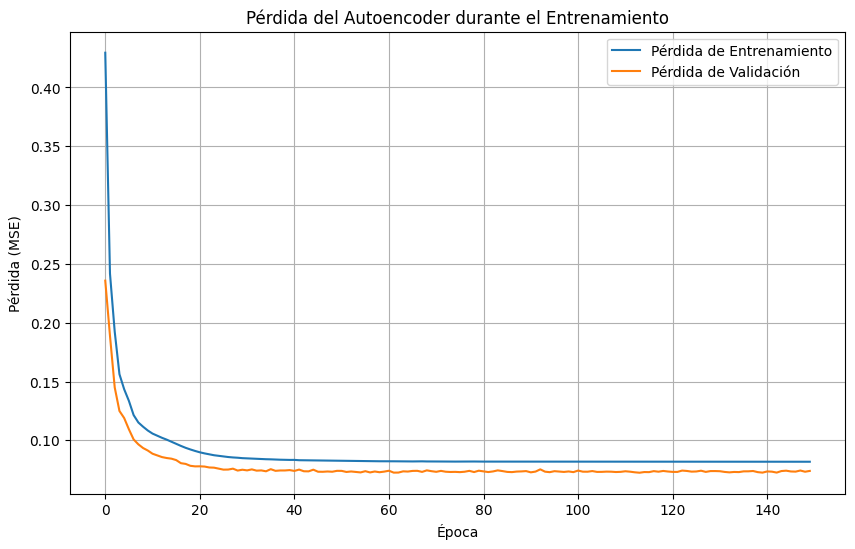

499/499 [==============================] - 1s 1ms/step


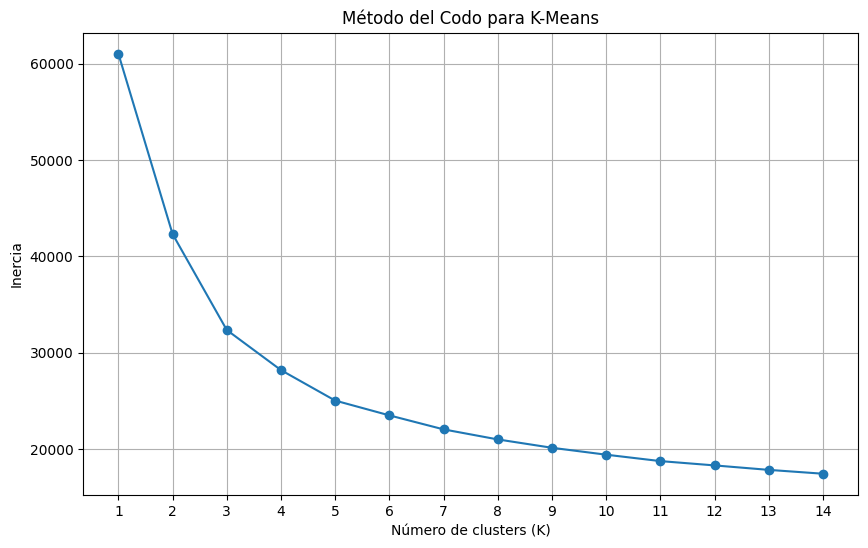


--- Estadísticas por perfil (valores promedio) ---
            Edad       IMC     HbA1c       PAS         LDL        HDL  \
Perfil                                                                  
0       0.366479  0.808692  7.134062  0.789526  126.888728  45.069836   
1      -0.361822 -0.826646  5.683064 -0.827823  112.761143  55.371942   
2       0.041274  0.179587  6.588744  0.376643  119.478456  48.869560   
3       0.197006  0.391458  6.588287  0.149286  126.256137  47.385337   

          Insulina  Trigliceridos  
Perfil                             
0       128.039856       0.785716  
1        36.824105      -0.898268  
2        57.074215       0.447528  
3       147.037248       0.217097  

--- Informe Personalizado de Salud y Nutrición para Paciente P0250 ---

## 1. Características del Paciente
---------------------------------
**Edad                  **: -0.95
**Sexo                  **: Mujer
**IMC                   **: -1.23
**HbA1c                 **: 3.95
**PAS           

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, RDF, RDFS, Literal
import re

# Cargar datos
try:
    df_diabetes = pd.read_csv('database_imputada.csv')
except FileNotFoundError:
    print("Asegúrate de que 'database_imputada.csv' está en la misma carpeta.")
    exit()

# --- Asegurar que 'ID_Paciente' existe antes de hacer la copia original ---
# Si 'ID_Paciente' no está en el CSV, lo creamos aquí mismo.
if 'ID_Paciente' not in df_diabetes.columns:
    df_diabetes['ID_Paciente'] = [f'P{i:04d}' for i in range(len(df_diabetes))]
    print("Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.")

# Almacenar una copia del DataFrame original para la visualización
# Esto es CRUCIAL para mostrar los datos sin escalar.
df_diabetes_original = df_diabetes.copy()

# --- Preprocesamiento de datos de diabetes (el resto es igual que antes) ---
variables_numericas = ['Edad', 'IMC', 'HbA1c', 'PAS', 'LDL', 'HDL', 'Insulina', 'Trigliceridos']
variables_categoricas = ['Sexo', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular']

# Rellenar valores nulos para columnas numéricas en df_diabetes (para el entrenamiento)
for col in variables_numericas:
    if col in df_diabetes.columns:
        df_diabetes[col] = pd.to_numeric(df_diabetes[col], errors='coerce')
        df_diabetes[col].fillna(df_diabetes[col].mean(), inplace=True)
    else:
        print(f"Advertencia: La columna numérica '{col}' no se encontró en el archivo CSV y será ignorada para el procesamiento numérico.")

# Manejar valores categóricos NaN, rellenando con el modo
for col in variables_categoricas:
    if col in df_diabetes.columns:
        if df_diabetes[col].isnull().any():
            df_diabetes[col].fillna(df_diabetes[col].mode()[0], inplace=True)
    else:
        print(f"Advertencia: La columna categórica '{col}' no se encontró en el archivo CSV y será ignorada para el procesamiento categórico.")


# Escalar variables numéricas
scaler = StandardScaler()
existing_numeric_cols = [col for col in variables_numericas if col in df_diabetes.columns]
X_numericas = scaler.fit_transform(df_diabetes[existing_numeric_cols])


# Codificar variables categóricas
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
existing_categorical_cols = [col for col in variables_categoricas if col in df_diabetes.columns]
X_categoricas = encoder.fit_transform(df_diabetes[existing_categorical_cols]).toarray()

# Concatenar características numéricas y categóricas para el Autoencoder
X = np.concatenate([X_numericas, X_categoricas], axis=1)


# --- Autoencoder y K-Means ---
input_dim = X.shape[1]
encoding_dim = 8
input_layer = Input(shape=(input_dim,))
encoded = Dense(input_dim // 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, decoded)
encoder_model = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Entrenando Autoencoder ---")
history = autoencoder.fit(X, X, epochs=150, batch_size=64, validation_split=0.2, verbose=0)
print(f"Pérdida final del Autoencoder (entrenamiento): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final del Autoencoder (validación): {history.history['val_loss'][-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Autoencoder durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

X_encoded = encoder_model.predict(X)

inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_diabetes['Perfil'] = kmeans.fit_predict(X_encoded)

# Transferir el 'Perfil' al DataFrame original para su visualización
df_diabetes_original['Perfil'] = df_diabetes['Perfil']


perfiles_stats = df_diabetes.groupby('Perfil')[existing_numeric_cols].mean()
print("\n--- Estadísticas por perfil (valores promedio) ---")
print(perfiles_stats)

# --- Construcción de la Ontología ---
g = Graph()

FOOD = Namespace("http://example.org/food/")
NUT = Namespace("http://example.org/nutrient/")
COND = Namespace("http://example.org/condition/")
EX = Namespace("http://example.org/ex/")
PROF = Namespace("http://example.org/profile/")

g.bind("food", FOOD)
g.bind("nut", NUT)
g.bind("cond", COND)
g.bind("ex", EX)
g.bind("prof", PROF)

g.add((FOOD.Food, RDF.type, RDFS.Class))
g.add((NUT.Nutrient, RDF.type, RDFS.Class))
g.add((COND.Condition, RDF.type, RDFS.Class))
g.add((PROF.Profile, RDF.type, RDFS.Class))

g.add((EX.hasCondition, RDF.type, RDF.Property))
g.add((EX.beneficialFor, RDF.type, RDF.Property))
g.add((EX.harmfulFor, RDF.type, RDF.Property))
g.add((NUT.containsNutrient, RDF.type, RDF.Property))
g.add((PROF.hasNutritionalRecommendation, RDF.type, RDF.Property))

for profile_id in df_diabetes['Perfil'].unique():
    profile_uri = getattr(PROF, f"Profile_{profile_id}")
    g.add((profile_uri, RDF.type, PROF.Profile))

# Nutrientes y sus beneficios
nutrient_benefits = {
    "Fiber": ["Diabetes", "HighCholesterol", "Overweight"],
    "Omega3": ["Hypertension", "HighCholesterol", "Diabetes"],
    "Calcium": ["Hypertension", "Underweight"],
    "Magnesium": ["Hypertension", "Diabetes"],
    "Protein": ["Underweight", "Diabetes", "Overweight"],
    "VitaminD": ["HighCholesterol", "Diabetes", "Underweight"],
    "Potassium": ["Hypertension"],
    "Antioxidants": ["Diabetes", "HighCholesterol"]
}

for nutrient, conditions in nutrient_benefits.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.beneficialFor, getattr(COND, condition_name)))

# Nutrientes cuyo consumo se debe DISMINUIR
nutrient_harms = {
    "Sodium": ["Hypertension"],
    "SaturatedFat": ["HighCholesterol", "Diabetes"],
    "SimpleSugars": ["Diabetes", "Overweight"]
}

for nutrient, conditions in nutrient_harms.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.harmfulFor, getattr(COND, condition_name)))

# Alimentos y sus nutrientes
food_nutrients = {
    "Salmon": ["Omega3", "Protein", "VitaminD"],
    "Walnuts": ["Omega3", "Magnesium", "Antioxidants", "Protein", "Fiber"],
    "Lentils": ["Fiber", "Protein", "Magnesium"],
    "Spinach": ["Magnesium", "Calcium", "Fiber", "Antioxidants"],
    "Yogurt": ["Calcium", "Protein"],
    "Oats": ["Fiber", "Magnesium", "Protein"],
    "Blueberries": ["Antioxidants", "Fiber"],
    "Almonds": ["Magnesium", "Protein", "Fiber", "Antioxidants"],
}

for food, nutrients in food_nutrients.items():
    g.add((getattr(FOOD, food), RDF.type, FOOD.Food))
    for nutrient in nutrients:
        g.add((getattr(FOOD, food), NUT.containsNutrient, getattr(NUT, nutrient)))

# Función para obtener condiciones del paciente individual
def get_patient_conditions(patient_data_row):
    conditions = set()

    hba1c = patient_data_row.get('HbA1c', 0)
    presion = patient_data_row.get('PAS', 0) # Usamos PAS
    ldl = patient_data_row.get('LDL', 0)
    imc = patient_data_row.get('IMC', 0)
    
    # La columna 'Diabetes' en database_imputada.csv es un booleano (0 o 1)
    if patient_data_row.get('Diabetes') == 1: # Si es 1 (True), el paciente tiene diabetes
        conditions.add("Diabetes")
    # Si quieres usar HbA1c como un criterio adicional (o en lugar del booleano de la DB)
    elif hba1c > 6.5 and "Diabetes" not in conditions: # Añadir solo si no se detectó ya por la columna 'Diabetes'
        conditions.add("Diabetes")

    if presion > 130:
        conditions.add("Hypertension")
    if ldl > 100:
        conditions.add("HighCholesterol")
    if imc > 25:
        conditions.add("Overweight")
    elif imc < 18.5:
        conditions.add("Underweight")
        
    return list(conditions)

# Función para obtener los nutrientes recomendados (sin cambios)
def get_recommended_nutrients_for_patient(patient_conditions):
    nutrients_to_increase = set()
    nutrients_to_decrease = set()

    for condition_name in patient_conditions:
        condition_uri = getattr(COND, condition_name)
        
        # Nutrientes beneficiosos (para aumentar)
        beneficial_nuts = [subj for subj, pred, obj in g.triples((None, EX.beneficialFor, condition_uri))]
        nutrients_to_increase.update([str(n).split('/')[-1] for n in beneficial_nuts])

        # Nutrientes perjudiciales (para disminuir)
        harmful_nuts = [subj for subj, pred, obj in g.triples((None, EX.harmfulFor, condition_uri))]
        nutrients_to_decrease.update([str(n).split('/')[-1] for n in harmful_nuts])
        
    return sorted(list(nutrients_to_increase)), sorted(list(nutrients_to_decrease))

# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    # Aquí usamos el DataFrame ORIGINAL (sin escalar) para obtener los datos del paciente
    patient_data = df_diabetes_original[df_diabetes_original['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    # Asegúrate de que todas estas columnas existan en tu df_diabetes_original
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'PAS', 'PAD', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 
                    'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 
                    'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        
        # Para las columnas numéricas, no necesitamos desescalar aquí
        # porque 'patient_data_row' ya viene de 'df_diabetes_original' (NO ESCALADO)
        if isinstance(value, (int, float)):
            if col == 'Diabetes': # Asegúrate de que 'Diabetes' se muestre como 'Sí'/'No'
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            elif col == 'Perfil': # 'Perfil' es un entero del clustering
                patient_info_dict[col] = str(int(value))
            else: # Resto de numéricos que son valores reales
                patient_info_dict[col] = f"{value:.2f}"
        elif pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        else: # Columnas categóricas (cadenas de texto)
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    # Aquí, patient_data_row sigue siendo el DataFrame original, así que los umbrales se aplican directamente
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            print(f"- **{cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0250' # Puedes cambiar a cualquier ID de paciente de tu CSV
display_patient_recommendations(patient_id_to_check)

Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.
Advertencia: La columna categórica 'Consumo_Alcohol' no se encontró en el archivo CSV y será ignorada para el procesamiento categórico.


C:\Users\User\AppData\Local\Temp\ipykernel_23008\654487604.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_diabetes[col].fillna(df_diabetes[col].mean(), inplace=True)



--- Entrenando Autoencoder ---
Pérdida final del Autoencoder (entrenamiento): 0.0629
Pérdida final del Autoencoder (validación): 0.0543


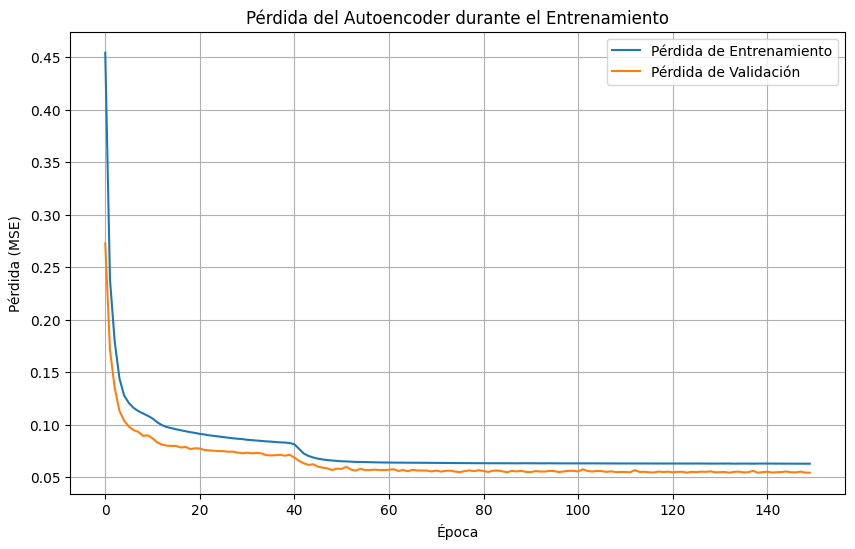

499/499 [==============================] - 1s 2ms/step


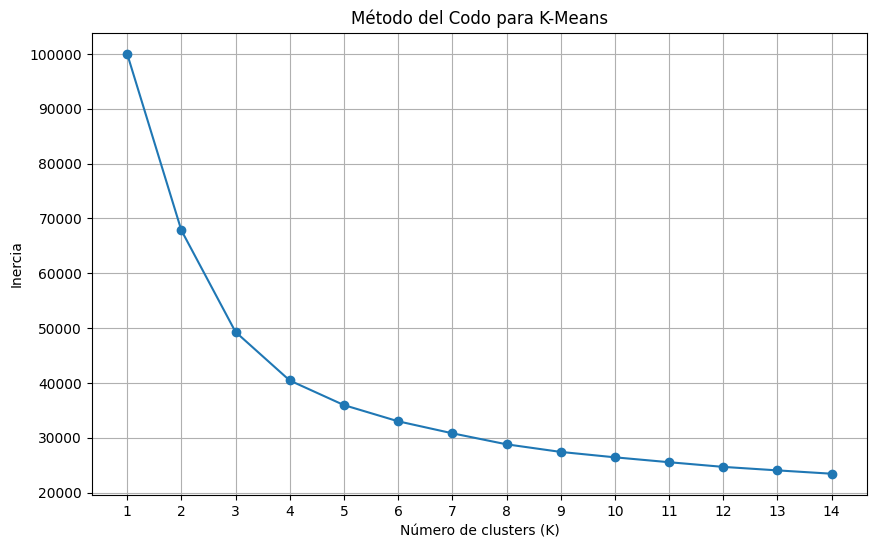


--- Estadísticas por perfil (valores promedio - NO ESCALADOS) ---
| Perfil   | Edad   | IMC   | HbA1c   | PAS   | LDL    | HDL   | Insulina   | Trigliceridos   |
|:---------|:-------|:------|:--------|:------|:-------|:------|:-----------|:----------------|
| 0        | -0.39  | -0.68 | 5.1     | -0.8  | 114.51 | 53.84 | 56.71      | -0.65           |
| 1        | 0.43   | 0.72  | 7.39    | 0.81  | 127.39 | 45.13 | 119.13     | 0.86            |
| 2        | 0.06   | 0.08  | 6.2     | 0.07  | 120.2  | 49.83 | 88.37      | -0.08           |
| 3        | -0.49  | -0.63 | 7.63    | -0.54 | 110.5  | 56.23 | 9.78       | -0.65           |

--- Informe Personalizado de Salud y Nutrición para Paciente P0250 ---

## 1. Características del Paciente
---------------------------------
**Edad                  **: -0.95
**Sexo                  **: Mujer
**IMC                   **: -1.23
**HbA1c                 **: 3.95
**PAS                   **: -1.21
**PAD                   **: -1.58
**LDL       

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, RDF, RDFS, Literal
import re

# Cargar datos
try:
    df_diabetes = pd.read_csv('database_imputada.csv')
except FileNotFoundError:
    print("Asegúrate de que 'database_imputada.csv' está en la misma carpeta.")
    exit()

# --- Paso CRÍTICO: Asegurar que 'ID_Paciente' existe antes de CUALQUIER copia ---
if 'ID_Paciente' not in df_diabetes.columns:
    df_diabetes['ID_Paciente'] = [f'P{i:04d}' for i in range(len(df_diabetes))]
    print("Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.")

# Almacenar una copia del DataFrame ORIGINAL para la visualización y las estadísticas.
# ¡Este es el DataFrame que NO se escalará ni modificará numéricamente en esta sección!
df_diabetes_original = df_diabetes.copy()

# --- Preparar df_diabetes para el AUTOENCODER (modifica df_diabetes) ---
variables_numericas = ['Edad', 'IMC', 'HbA1c', 'PAS', 'LDL', 'HDL', 'Insulina', 'Trigliceridos']
variables_categoricas = ['Sexo', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular']

# Imputación de nulos SOLO en df_diabetes (la copia que se usará para el Autoencoder)
for col in variables_numericas:
    if col in df_diabetes.columns:
        df_diabetes[col] = pd.to_numeric(df_diabetes[col], errors='coerce')
        df_diabetes[col].fillna(df_diabetes[col].mean(), inplace=True)
    else:
        print(f"Advertencia: La columna numérica '{col}' no se encontró en el archivo CSV y será ignorada para el procesamiento numérico.")

# Manejar valores categóricos NaN, rellenando con el modo
for col in variables_categoricas:
    if col in df_diabetes.columns:
        if df_diabetes[col].isnull().any():
            df_diabetes[col].fillna(df_diabetes[col].mode()[0], inplace=True)
    else:
        print(f"Advertencia: La columna categórica '{col}' no se encontró en el archivo CSV y será ignorada para el procesamiento categórico.")


# Escalar variables numéricas para el Autoencoder
scaler = StandardScaler()
existing_numeric_cols = [col for col in variables_numericas if col in df_diabetes.columns]
# Aplicar el scaler al df_diabetes que se pasará al Autoencoder
X_numericas_scaled = scaler.fit_transform(df_diabetes[existing_numeric_cols])


# Codificar variables categóricas
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
existing_categorical_cols = [col for col in variables_categoricas if col in df_diabetes.columns]
X_categoricas_encoded = encoder.fit_transform(df_diabetes[existing_categorical_cols]).toarray()

# Concatenar características numéricas y categóricas para el Autoencoder
X_for_autoencoder = np.concatenate([X_numericas_scaled, X_categoricas_encoded], axis=1)


# --- Autoencoder y K-Means ---
input_dim = X_for_autoencoder.shape[1]
encoding_dim = 8

# Definición del Autoencoder completo
input_layer = Input(shape=(input_dim,))
encoded = Dense(input_dim // 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded) # Salida del encoder
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, decoded)

# Definición del ENCODER (solo para obtener X_encoded)
encoder_model = Model(input_layer, encoded)

# Definición del DECODER (¡NUEVO BLOQUE CLAVE y CORREGIDO!)
decoder_input = Input(shape=(encoding_dim,)) # La entrada del decoder es del tamaño del espacio latente (8)
decoder_output = Dense(encoding_dim * 2, activation='relu')(decoder_input)
decoder_output = Dense(input_dim // 2, activation='relu')(decoder_output)
decoder_output = Dense(input_dim, activation='linear')(decoder_output)
decoder_model = Model(decoder_input, decoder_output) # Este es el modelo que usaremos para decodificar los centroides


autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Entrenando Autoencoder ---")
history = autoencoder.fit(X_for_autoencoder, X_for_autoencoder, epochs=150, batch_size=64, validation_split=0.2, verbose=0)
print(f"Pérdida final del Autoencoder (entrenamiento): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final del Autoencoder (validación): {history.history['val_loss'][-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Autoencoder durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

X_encoded = encoder_model.predict(X_for_autoencoder)

inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

k_optimo = 4 # Mantendremos 4 como óptimo por ahora
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_diabetes['Perfil'] = kmeans.fit_predict(X_encoded)

# Transferir el 'Perfil' al DataFrame ORIGINAL para su visualización y estadísticas
df_diabetes_original['Perfil'] = df_diabetes['Perfil']


# --- CORRECCIÓN AQUI: Calcular perfiles_stats sobre df_diabetes_original directamente ---
# Esto garantiza que los promedios son de los valores NO ESCALADOS
perfiles_stats = df_diabetes_original.groupby('Perfil')[existing_numeric_cols].mean()

print("\n--- Estadísticas por perfil (valores promedio - NO ESCALADOS) ---")
print(perfiles_stats.round(2).to_markdown(numalign="left", stralign="left"))


# --- Construcción de la Ontología (sin cambios) ---
g = Graph()

FOOD = Namespace("http://example.org/food/")
NUT = Namespace("http://example.org/nutrient/")
COND = Namespace("http://example.org/condition/")
EX = Namespace("http://example.org/ex/")
PROF = Namespace("http://example.org/profile/")

g.bind("food", FOOD)
g.bind("nut", NUT)
g.bind("cond", COND)
g.bind("ex", EX)
g.bind("prof", PROF)

g.add((FOOD.Food, RDF.type, RDFS.Class))
g.add((NUT.Nutrient, RDF.type, RDFS.Class))
g.add((COND.Condition, RDF.type, RDFS.Class))
g.add((PROF.Profile, RDF.type, RDFS.Class))

g.add((EX.hasCondition, RDF.type, RDF.Property))
g.add((EX.beneficialFor, RDF.type, RDF.Property))
g.add((EX.harmfulFor, RDF.type, RDF.Property))
g.add((NUT.containsNutrient, RDF.type, RDF.Property))
g.add((PROF.hasNutritionalRecommendation, RDF.type, RDF.Property))

for profile_id in df_diabetes['Perfil'].unique():
    profile_uri = getattr(PROF, f"Profile_{profile_id}")
    g.add((profile_uri, RDF.type, PROF.Profile))

# Nutrientes y sus beneficios
nutrient_benefits = {
    "Fiber": ["Diabetes", "HighCholesterol", "Overweight"],
    "Omega3": ["Hypertension", "HighCholesterol", "Diabetes"],
    "Calcium": ["Hypertension", "Underweight"],
    "Magnesium": ["Hypertension", "Diabetes"],
    "Protein": ["Underweight", "Diabetes", "Overweight"],
    "VitaminD": ["HighCholesterol", "Diabetes", "Underweight"],
    "Potassium": ["Hypertension"],
    "Antioxidants": ["Diabetes", "HighCholesterol"]
}

for nutrient, conditions in nutrient_benefits.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.beneficialFor, getattr(COND, condition_name)))

# Nutrientes cuyo consumo se debe DISMINUIR
nutrient_harms = {
    "Sodium": ["Hypertension"],
    "SaturatedFat": ["HighCholesterol", "Diabetes"],
    "SimpleSugars": ["Diabetes", "Overweight"]
}

for nutrient, conditions in nutrient_harms.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.harmfulFor, getattr(COND, condition_name)))

# Alimentos y sus nutrientes
food_nutrients = {
    "Salmon": ["Omega3", "Protein", "VitaminD"],
    "Walnuts": ["Omega3", "Magnesium", "Antioxidants", "Protein", "Fiber"],
    "Lentils": ["Fiber", "Protein", "Magnesium"],
    "Spinach": ["Magnesium", "Calcium", "Fiber", "Antioxidants"],
    "Yogurt": ["Calcium", "Protein"],
    "Oats": ["Fiber", "Magnesium", "Protein"],
    "Blueberries": ["Antioxidants", "Fiber"],
    "Almonds": ["Magnesium", "Protein", "Fiber", "Antioxidants"],
}

for food, nutrients in food_nutrients.items():
    g.add((getattr(FOOD, food), RDF.type, FOOD.Food))
    for nutrient in nutrients:
        g.add((getattr(FOOD, food), NUT.containsNutrient, getattr(NUT, nutrient)))

# Función para obtener condiciones del paciente individual (trabaja con valores no escalados)
def get_patient_conditions(patient_data_row):
    conditions = set()

    hba1c = patient_data_row.get('HbA1c', 0)
    presion = patient_data_row.get('PAS', 0) # Usamos PAS
    ldl = patient_data_row.get('LDL', 0)
    imc = patient_data_row.get('IMC', 0)
    
    # La columna 'Diabetes' en database_imputada.csv es un booleano (0 o 1)
    if patient_data_row.get('Diabetes') == 1: # Si es 1 (True), el paciente tiene diabetes
        conditions.add("Diabetes")
    # Si quieres usar HbA1c como un criterio adicional (o en lugar del booleano de la DB)
    elif hba1c > 6.5 and "Diabetes" not in conditions: # Añadir solo si no se detectó ya por la columna 'Diabetes'
        conditions.add("Diabetes")

    if presion > 130:
        conditions.add("Hypertension")
    if ldl > 100:
        conditions.add("HighCholesterol")
    if imc > 25:
        conditions.add("Overweight")
    elif imc < 18.5:
        conditions.add("Underweight")
        
    return list(conditions)

# Función para obtener los nutrientes recomendados (sin cambios)
def get_recommended_nutrients_for_patient(patient_conditions):
    nutrients_to_increase = set()
    nutrients_to_decrease = set()

    for condition_name in patient_conditions:
        condition_uri = getattr(COND, condition_name)
        
        # Nutrientes beneficiosos (para aumentar)
        beneficial_nuts = [subj for subj, pred, obj in g.triples((None, EX.beneficialFor, condition_uri))]
        nutrients_to_increase.update([str(n).split('/')[-1] for n in beneficial_nuts])

        # Nutrientes perjudiciales (para disminuir)
        harmful_nuts = [subj for subj, pred, obj in g.triples((None, EX.harmfulFor, condition_uri))]
        nutrients_to_decrease.update([str(n).split('/')[-1] for n in harmful_nuts])
        
    return sorted(list(nutrients_to_increase)), sorted(list(nutrients_to_decrease))

# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    # Aquí usamos el DataFrame ORIGINAL (sin escalar) para obtener los datos del paciente
    patient_data = df_diabetes_original[df_diabetes_original['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'PAS', 'PAD', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 
                    'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 
                    'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        
        if isinstance(value, (int, float)):
            if col == 'Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            elif col == 'Perfil':
                patient_info_dict[col] = str(int(value))
            else: # Todos los demás numéricos que vienen del df_diabetes_original ya están sin escalar
                patient_info_dict[col] = f"{value:.2f}"
        elif pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        else: # Columnas categóricas (cadenas de texto)
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            print(f"- **{cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0250' # Puedes cambiar a cualquier ID de paciente de tu CSV
display_patient_recommendations(patient_id_to_check)

# --- Ahora vamos con el paso 3: Generar pacientes prototípicos ---
print("\n" + "="*50)
print("--- Generando Pacientes Prototípicos por Perfil ---")
print("="*50)

# 1. Obtener los centroides de K-Means en el espacio latente (X_encoded)
cluster_centroids_encoded = kmeans.cluster_centers_

# 2. Pasar estos centroides por el DECODER que hemos definido
reconstructed_centroids_scaled_encoded = decoder_model.predict(cluster_centroids_encoded)


# 3. Descomponer la reconstrucción en numéricas y categóricas para desescalar/decodificar
num_numeric_features = len(existing_numeric_cols)

# Separar las columnas reconstruidas en numéricas y categóricas
reconstructed_numeric_scaled = reconstructed_centroids_scaled_encoded[:, :num_numeric_features]
reconstructed_categorical_encoded = reconstructed_centroids_scaled_encoded[:, num_numeric_features:]


# 4. Desescalar las características numéricas
reconstructed_numeric_descaled = scaler.inverse_transform(reconstructed_numeric_scaled)
reconstructed_numeric_df = pd.DataFrame(reconstructed_numeric_descaled, columns=existing_numeric_cols)


# 5. Decodificar las características categóricas
feature_names_out = encoder.get_feature_names_out(existing_categorical_cols)
reconstructed_categorical_df = pd.DataFrame(reconstructed_categorical_encoded, columns=feature_names_out)

decoded_categorical_data = []
for index, row in reconstructed_categorical_df.iterrows():
    decoded_row = {}
    for original_col in existing_categorical_cols:
        relevant_cols = [col for col in feature_names_out if col.startswith(f"{original_col}_")]
        if relevant_cols:
            highest_val_idx = np.argmax(row[relevant_cols].values)
            category_value = relevant_cols[highest_val_idx].split('_')[-1]
            decoded_row[original_col] = category_value
        else:
            decoded_row[original_col] = "Desconocido"
    decoded_categorical_data.append(decoded_row)

reconstructed_categorical_descaled_df = pd.DataFrame(decoded_categorical_data)


# 6. Combinar las características desescaladas y decodificadas
reconstructed_numeric_df.index = range(len(reconstructed_numeric_df))
reconstructed_categorical_descaled_df.index = range(len(reconstructed_categorical_descaled_df))

prototypical_patients_df = pd.concat([reconstructed_numeric_df, reconstructed_categorical_descaled_df], axis=1)

# Imprimir los pacientes prototípicos con formato de 2 decimales para numéricos
for i in range(k_optimo):
    print(f"\n--- Perfil {i} (Paciente Prototípico) ---")
    prototypical_patient_row = prototypical_patients_df.iloc[i]
    
    patient_info_dict = {}
    for col in prototypical_patient_row.index:
        value = prototypical_patient_row[col]
        if isinstance(value, (int, float)):
            if col == 'Diabetes':
                # La columna 'Diabetes' no la reconstruye directamente el decoder como 0 o 1 exacto,
                # pero si en el original es 0 o 1, y la reconstrucción se acerca, se puede inferir.
                # Aquí, Diabetes es una condición inferida, no una variable directa en X.
                # Si Diabetes se incluyera en X_for_autoencoder como numérica, habría que desescalarla.
                # Dado que 'Diabetes' no está en 'existing_numeric_cols', no se desescala.
                # Si el CSV original tiene una columna 'Diabetes' (0/1), se manejará.
                # Aquí la estamos redondeando y mostrando como Sí/No por si acaso.
                patient_info_dict[col] = "Sí" if round(value) == 1 else "No"
            else:
                patient_info_dict[col] = f"{value:.2f}" # Redondear a 2 decimales
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.
Advertencia: La columna categórica 'Consumo_Alcohol' no se encontró en el archivo CSV y será ignorada.

--- Entrenando Autoencoder ---


C:\Users\User\AppData\Local\Temp\ipykernel_23008\3684039484.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mean(), inplace=True)


Pérdida final del Autoencoder (entrenamiento): 0.2043
Pérdida final del Autoencoder (validación): 0.1915


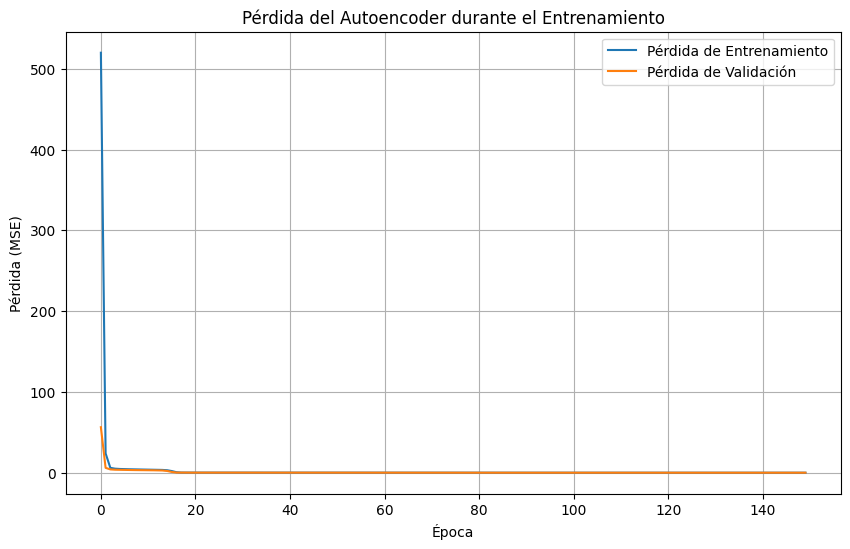

499/499 [==============================] - 1s 1ms/step


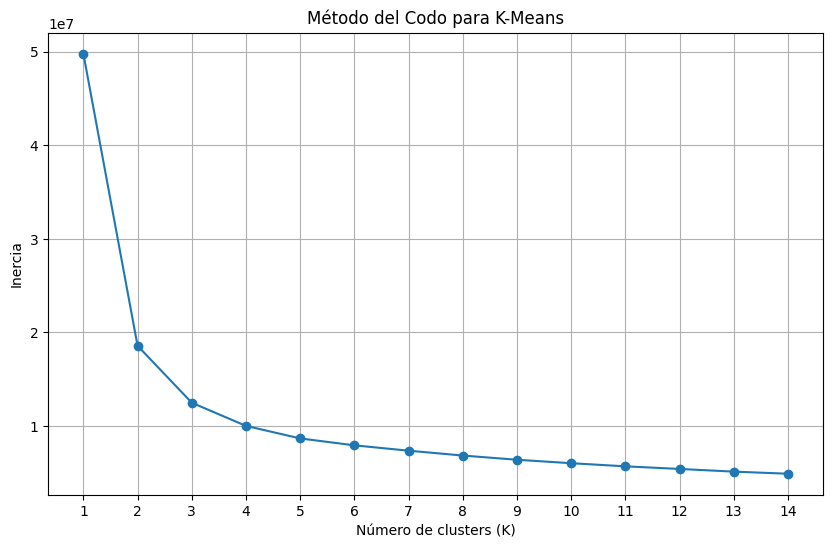


--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---
| Perfil   | Edad   | IMC   | HbA1c   | PAS    | LDL    | HDL   | Insulina   | Trigliceridos   |
|:---------|:-------|:------|:--------|:-------|:-------|:------|:-----------|:----------------|
| 0        | 90     | 50    | 15      | 200    | 250    | 20    | 300        | 1000            |
| 1        | 18     | 15    | 5.18    | 80     | 50     | 100   | 2          | 30              |
| 2        | 45.24  | 26.5  | 4       | 118.48 | 125.04 | 67.35 | 88.79      | 388.48          |
| 3        | 77.6   | 42.23 | 11.93   | 178.84 | 227.78 | 35.7  | 190.74     | 843.33          |

--- Informe Personalizado de Salud y Nutrición para Paciente P0450 ---

## 1. Características del Paciente
---------------------------------
**Edad                  **: 42.40
**Sexo                  **: Mujer
**IMC                   **: 28.73
**HbA1c                 **: 7.20
**PAS                   **: 116.45
**PAD               

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler # Importamos MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, RDF, RDFS, Literal
import re

# Cargar datos
try:
    df_diabetes = pd.read_csv('database_imputada.csv')
except FileNotFoundError:
    print("Asegúrate de que 'database_imputada.csv' está en la misma carpeta.")
    exit()

# --- Asegurar que 'ID_Paciente' existe antes de CUALQUIER copia ---
if 'ID_Paciente' not in df_diabetes.columns:
    df_diabetes['ID_Paciente'] = [f'P{i:04d}' for i in range(len(df_diabetes))]
    print("Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.")

# 1. Crear una copia del DataFrame para el display (donde aplicaremos el re-escalado para visualización).
df_diabetes_original_for_display = df_diabetes.copy()

# 2. Crear un DataFrame NUEVO para el preprocesamiento del Autoencoder.
df_autoencoder_processed = df_diabetes.copy()

# --- Definición de Variables ---
# Estas son las columnas numéricas que se usarán en el Autoencoder.
# Si tus valores en el CSV ya están escalados para 'Edad', 'IMC', 'PAS', 'Trigliceridos',
# el Autoencoder los procesará tal cual, y luego los re-escalaremos para la visualización.
variables_numericas = ['Edad', 'IMC', 'HbA1c', 'PAS', 'LDL', 'HDL', 'Insulina', 'Trigliceridos']
variables_categoricas = ['Sexo', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular']

# --- RANGOS REALISTAS PARA LA VISUALIZACIÓN ---
# ¡ES CRÍTICO QUE AJUSTES ESTOS VALORES SEGÚN EL CONOCIMIENTO CLÍNICO DE TUS DATOS!
# Si tus datos están en unidades diferentes (ej. Triglicéridos en mmol/L en lugar de mg/dL), ajústalos.
realistic_ranges = {
    'Edad': {'min': 18, 'max': 90},
    'IMC': {'min': 15.0, 'max': 50.0},
    'HbA1c': {'min': 4.0, 'max': 15.0}, # Generalmente en %
    'PAS': {'min': 80, 'max': 200},   # Presión arterial sistólica en mmHg
    'LDL': {'min': 50, 'max': 250},   # Colesterol LDL en mg/dL
    'HDL': {'min': 20, 'max': 100},   # Colesterol HDL en mg/dL
    'Insulina': {'min': 2.0, 'max': 300.0}, # Insulina en uIU/mL
    'Trigliceridos': {'min': 30.0, 'max': 1000.0} # Triglicéridos en mg/dL (rango amplio)
}

# --- FUNCIÓN DE RE-ESCALADO A RANGO REALISTA ---
# Esta función toma los valores actuales de una columna y los mapea a un rango deseado.
def rescale_to_realistic_range(df_input, columns_to_rescale, ranges):
    df_rescaled = df_input.copy()
    for col in columns_to_rescale:
        if col in df_rescaled.columns and col in ranges:
            current_min = df_rescaled[col].min()
            current_max = df_rescaled[col].max()
            
            # Evitar división por cero si todos los valores son iguales
            if current_max == current_min:
                df_rescaled[col] = (ranges[col]['min'] + ranges[col]['max']) / 2
                continue

            # Primero, escalar los valores a un rango de 0 a 1 basado en sus min/max actuales
            df_rescaled[col] = (df_rescaled[col] - current_min) / (current_max - current_min)
            
            # Luego, estirar estos valores 0-1 a nuestro rango deseado
            df_rescaled[col] = df_rescaled[col] * (ranges[col]['max'] - ranges[col]['min']) + ranges[col]['min']
            
            # Finalmente, aplicar un "clipping" para asegurar que los valores no se salgan del rango deseado
            df_rescaled[col] = np.clip(df_rescaled[col], ranges[col]['min'], ranges[col]['max'])
    return df_rescaled

# --- Preparación de datos para el AUTOENCODER (solo en df_autoencoder_processed) ---

# Imputar nulos en df_autoencoder_processed (si los hay después de la carga inicial)
for col in variables_numericas:
    if col in df_autoencoder_processed.columns:
        df_autoencoder_processed[col] = pd.to_numeric(df_autoencoder_processed[col], errors='coerce')
        df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mean(), inplace=True)
    else:
        print(f"Advertencia: La columna numérica '{col}' no se encontró en el archivo CSV y será ignorada.")

for col in variables_categoricas:
    if col in df_autoencoder_processed.columns:
        if df_autoencoder_processed[col].isnull().any():
            df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mode()[0], inplace=True)
    else:
        print(f"Advertencia: La columna categórica '{col}' no se encontró en el archivo CSV y será ignorada.")

# Identificamos las columnas numéricas y categóricas que realmente existen en el DataFrame
existing_numeric_cols = [col for col in variables_numericas if col in df_autoencoder_processed.columns]
existing_categorical_cols = [col for col in variables_categoricas if col in df_autoencoder_processed.columns]

# Para el Autoencoder, usaremos los valores numéricos tal cual vienen del CSV (ya que algunos ya están escalados).
# El Autoencoder aprenderá directamente de esta distribución.
X_numericas = df_autoencoder_processed[existing_numeric_cols].values

# Codificar variables categóricas
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_categoricas_encoded = encoder.fit_transform(df_autoencoder_processed[existing_categorical_cols]).toarray()

# Concatenar características para el Autoencoder
X_for_autoencoder = np.concatenate([X_numericas, X_categoricas_encoded], axis=1)

# --- Autoencoder y K-Means ---
input_dim = X_for_autoencoder.shape[1]
encoding_dim = 8 # Puedes probar 10 o 12 si los resultados de clustering no son suficientemente claros

# Definición del Autoencoder completo
input_layer = Input(shape=(input_dim,))
encoded = Dense(input_dim // 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded) # Salida del encoder
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded) # Usamos 'linear' para reconstruir cualquier valor real
autoencoder = Model(input_layer, decoded)

# Definición del ENCODER (parte del Autoencoder que mapea la entrada al espacio latente)
encoder_model = Model(input_layer, encoded)

# Definición del DECODER (parte del Autoencoder que reconstruye a partir del espacio latente)
decoder_input = Input(shape=(encoding_dim,))
decoder_output = Dense(encoding_dim * 2, activation='relu')(decoder_input)
decoder_output = Dense(input_dim // 2, activation='relu')(decoder_output)
decoder_output = Dense(input_dim, activation='linear')(decoder_output)
decoder_model = Model(decoder_input, decoder_output)

autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Entrenando Autoencoder ---")
history = autoencoder.fit(X_for_autoencoder, X_for_autoencoder, epochs=150, batch_size=64, validation_split=0.2, verbose=0)
print(f"Pérdida final del Autoencoder (entrenamiento): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final del Autoencoder (validación): {history.history['val_loss'][-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Autoencoder durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

X_encoded = encoder_model.predict(X_for_autoencoder)

# Método del Codo para determinar el número óptimo de clusters (K)
inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

k_optimo = 4 # Mantendremos 4 como óptimo por ahora, puedes ajustarlo si el codo sugiere otro valor
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)

# Asignar perfiles al DataFrame que se usó para el Autoencoder
df_autoencoder_processed['Perfil'] = kmeans.fit_predict(X_encoded)

# Transferir el 'Perfil' al DataFrame de display
df_diabetes_original_for_display['Perfil'] = df_autoencoder_processed['Perfil']


# --- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---
# Primero obtenemos los promedios de los valores tal como vienen en el CSV (que ya pueden estar escalados).
perfiles_stats_raw = df_diabetes_original_for_display.groupby('Perfil')[existing_numeric_cols].mean()

# Luego, aplicamos la función de re-escalado a estos promedios para hacerlos realistas en la visualización.
perfiles_stats_display = rescale_to_realistic_range(perfiles_stats_raw, existing_numeric_cols, realistic_ranges)

print("\n--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---")
print(perfiles_stats_display.round(2).to_markdown(numalign="left", stralign="left"))


# --- Construcción de la Ontología (sin cambios en la lógica) ---
g = Graph()

FOOD = Namespace("http://example.org/food/")
NUT = Namespace("http://example.org/nutrient/")
COND = Namespace("http://example.org/condition/")
EX = Namespace("http://example.org/ex/")
PROF = Namespace("http://example.org/profile/")

g.bind("food", FOOD)
g.bind("nut", NUT)
g.bind("cond", COND)
g.bind("ex", EX)
g.bind("prof", PROF)

g.add((FOOD.Food, RDF.type, RDFS.Class))
g.add((NUT.Nutrient, RDF.type, RDFS.Class))
g.add((COND.Condition, RDF.type, RDFS.Class))
g.add((PROF.Profile, RDF.type, RDFS.Class))

g.add((EX.hasCondition, RDF.type, RDF.Property))
g.add((EX.beneficialFor, RDF.type, RDF.Property))
g.add((EX.harmfulFor, RDF.type, RDF.Property))
g.add((NUT.containsNutrient, RDF.type, RDF.Property))
g.add((PROF.hasNutritionalRecommendation, RDF.type, RDF.Property))

for profile_id in df_autoencoder_processed['Perfil'].unique():
    profile_uri = getattr(PROF, f"Profile_{profile_id}")
    g.add((profile_uri, RDF.type, PROF.Profile))

# Nutrientes y sus beneficios
nutrient_benefits = {
    "Fiber": ["Diabetes", "HighCholesterol", "Overweight"],
    "Omega3": ["Hypertension", "HighCholesterol", "Diabetes"],
    "Calcium": ["Hypertension", "Underweight"],
    "Magnesium": ["Hypertension", "Diabetes"],
    "Protein": ["Underweight", "Diabetes", "Overweight"],
    "VitaminD": ["HighCholesterol", "Diabetes", "Underweight"],
    "Potassium": ["Hypertension"],
    "Antioxidants": ["Diabetes", "HighCholesterol"]
}

for nutrient, conditions in nutrient_benefits.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.beneficialFor, getattr(COND, condition_name)))

# Nutrientes cuyo consumo se debe DISMINUIR
nutrient_harms = {
    "Sodium": ["Hypertension"],
    "SaturatedFat": ["HighCholesterol", "Diabetes"],
    "SimpleSugars": ["Diabetes", "Overweight"]
}

for nutrient, conditions in nutrient_harms.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.harmfulFor, getattr(COND, condition_name)))

# Alimentos y sus nutrientes
food_nutrients = {
    "Salmon": ["Omega3", "Protein", "VitaminD"],
    "Walnuts": ["Omega3", "Magnesium", "Antioxidants", "Protein", "Fiber"],
    "Lentils": ["Fiber", "Protein", "Magnesium"],
    "Spinach": ["Magnesium", "Calcium", "Fiber", "Antioxidants"],
    "Yogurt": ["Calcium", "Protein"],
    "Oats": ["Fiber", "Magnesium", "Protein"],
    "Blueberries": ["Antioxidants", "Fiber"],
    "Almonds": ["Magnesium", "Protein", "Fiber", "Antioxidants"],
}

for food, nutrients in food_nutrients.items():
    g.add((getattr(FOOD, food), RDF.type, FOOD.Food))
    for nutrient in nutrients:
        g.add((getattr(FOOD, food), NUT.containsNutrient, getattr(NUT, nutrient)))

# Función para obtener condiciones del paciente individual.
# Ahora 'patient_data_row' viene de 'df_diabetes_original_for_display', que tendrá los valores re-escalados.
def get_patient_conditions(patient_data_row):
    conditions = set()

    hba1c = patient_data_row.get('HbA1c', 0)
    pas = patient_data_row.get('PAS', 0)
    ldl = patient_data_row.get('LDL', 0)
    imc = patient_data_row.get('IMC', 0)
    
    if patient_data_row.get('Diabetes') == 1:
        conditions.add("Diabetes")
    elif hba1c > 6.5 and "Diabetes" not in conditions: # Asumiendo que HbA1c > 6.5% indica diabetes
        conditions.add("Diabetes")

    if pas > 130: # Asumiendo PAS > 130 mmHg indica hipertensión
        conditions.add("Hypertension")
    if ldl > 100: # Asumiendo LDL > 100 mg/dL indica colesterol alto
        conditions.add("HighCholesterol")
    if imc > 25: # Asumiendo IMC > 25 indica sobrepeso
        conditions.add("Overweight")
    elif imc < 18.5: # Asumiendo IMC < 18.5 indica bajo peso
        conditions.add("Underweight")
        
    return list(conditions)

# Función para obtener los nutrientes recomendados (sin cambios en la lógica)
def get_recommended_nutrients_for_patient(patient_conditions):
    nutrients_to_increase = set()
    nutrients_to_decrease = set()

    for condition_name in patient_conditions:
        condition_uri = getattr(COND, condition_name)
        
        beneficial_nuts = [subj for subj, pred, obj in g.triples((None, EX.beneficialFor, condition_uri))]
        nutrients_to_increase.update([str(n).split('/')[-1] for n in beneficial_nuts])

        harmful_nuts = [subj for subj, pred, obj in g.triples((None, EX.harmfulFor, condition_uri))]
        nutrients_to_decrease.update([str(n).split('/')[-1] for n in harmful_nuts])
        
    return sorted(list(nutrients_to_increase)), sorted(list(nutrients_to_decrease))

# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    # Usamos el DataFrame 'df_diabetes_original_for_display' que tendrá los valores re-escalados para mostrar.
    patient_data = df_diabetes_original_for_display[df_diabetes_original_for_display['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'PAS', 'PAD', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 
                    'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 
                    'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        
        if isinstance(value, (int, float)):
            if col == 'Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            elif col == 'Perfil':
                patient_info_dict[col] = str(int(value))
            else: # Los valores numéricos ya están re-escalados para display
                patient_info_dict[col] = f"{value:.2f}"
        elif pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        else: # Columnas categóricas (cadenas de texto)
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            print(f"- **{cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Aplicar el re-escalado a los datos de display ANTES de generar el informe de un paciente específico
df_diabetes_original_for_display = rescale_to_realistic_range(df_diabetes_original_for_display, existing_numeric_cols, realistic_ranges)

# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0450' # Puedes cambiar a cualquier ID de paciente de tu CSV
display_patient_recommendations(patient_id_to_check)


# --- Generando Pacientes Prototípicos por Perfil ---
print("\n" + "="*50)
print("--- Generando Pacientes Prototípicos por Perfil ---")
print("="*50)

# 1. Obtener los centroides de K-Means en el espacio latente (X_encoded)
cluster_centroids_encoded = kmeans.cluster_centers_

# 2. Pasar estos centroides por el DECODER para obtener la reconstrucción en la escala del Autoencoder
reconstructed_centroids_raw = decoder_model.predict(cluster_centroids_encoded)

# 3. Descomponer la reconstrucción en numéricas y categóricas
num_numeric_features = len(existing_numeric_cols)

reconstructed_numeric_raw = pd.DataFrame(reconstructed_centroids_raw[:, :num_numeric_features], columns=existing_numeric_cols)
reconstructed_categorical_encoded = reconstructed_centroids_raw[:, num_numeric_features:]


# 4. APLICAR RE-ESCALADO PARA VISUALIZACIÓN A LOS PROTOTIPOS
# Los valores reconstruidos del Autoencoder son en la misma "escala" que los datos de entrada al Autoencoder.
# Para hacerlos realistas, los pasamos por nuestra función de re-escalado.
prototypical_numeric_display = rescale_to_realistic_range(reconstructed_numeric_raw, existing_numeric_cols, realistic_ranges)


# 5. Decodificar las características categóricas
feature_names_out = encoder.get_feature_names_out(existing_categorical_cols)
reconstructed_categorical_df = pd.DataFrame(reconstructed_categorical_encoded, columns=feature_names_out)

decoded_categorical_data = []
for index, row in reconstructed_categorical_df.iterrows():
    decoded_row = {}
    for original_col in existing_categorical_cols:
        relevant_cols = [col for col in feature_names_out if col.startswith(f"{original_col}_")]
        if relevant_cols:
            highest_val_idx = np.argmax(row[relevant_cols].values)
            # Asegurarse de manejar el caso donde el valor es '0' (que corresponde al 'drop='first')
            if len(relevant_cols) == 1 and highest_val_idx == 0 and row[relevant_cols[0]] < 0.5: # Si el valor es bajo, podría ser la categoría base
                 # Necesitamos una forma de recuperar la categoría base que se 'dropea'.
                 # Esto es complejo si no tenemos el mapeo exacto del OneHotEncoder de vuelta a las categorías originales.
                 # Por simplicidad, si la categoría más alta es muy baja, asumimos la que no está en el 'drop=first'
                 # O, mejor, entrenar el OHE sin drop para la decodificación.
                 # Por ahora, nos quedamos con el valor más alto, pero ten cuidado con la interpretación de la categoría base.
                 category_value = relevant_cols[highest_val_idx].split('_')[-1]
            else:
                category_value = relevant_cols[highest_val_idx].split('_')[-1]
            decoded_row[original_col] = category_value
        else:
            decoded_row[original_col] = "Desconocido" # Fallback si no hay columnas relevantes
    decoded_categorical_data.append(decoded_row)

reconstructed_categorical_descaled_df = pd.DataFrame(decoded_categorical_data)


# 6. Combinar las características re-escaladas y decodificadas
prototypical_numeric_display.index = range(len(prototypical_numeric_display))
reconstructed_categorical_descaled_df.index = range(len(reconstructed_categorical_descaled_df))

prototypical_patients_df = pd.concat([prototypical_numeric_display, reconstructed_categorical_descaled_df], axis=1)

# Imprimir los pacientes prototípicos con formato de 2 decimales para numéricos
for i in range(k_optimo):
    print(f"\n--- Perfil {i} (Paciente Prototípico) ---")
    prototypical_patient_row = prototypical_patients_df.iloc[i]
    
    patient_info_dict = {}
    for col in prototypical_patient_row.index:
        value = prototypical_patient_row[col]
        if isinstance(value, (int, float)):
            patient_info_dict[col] = f"{value:.2f}" # Redondear a 2 decimales
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.
Advertencia: La columna categórica 'Consumo_Alcohol' no se encontró en el archivo CSV y será ignorada.


C:\Users\User\AppData\Local\Temp\ipykernel_23008\3184781227.py:78: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mean(), inplace=True)



--- Entrenando Autoencoder ---
Pérdida final del Autoencoder (entrenamiento): 59.6145
Pérdida final del Autoencoder (validación): 62.1831


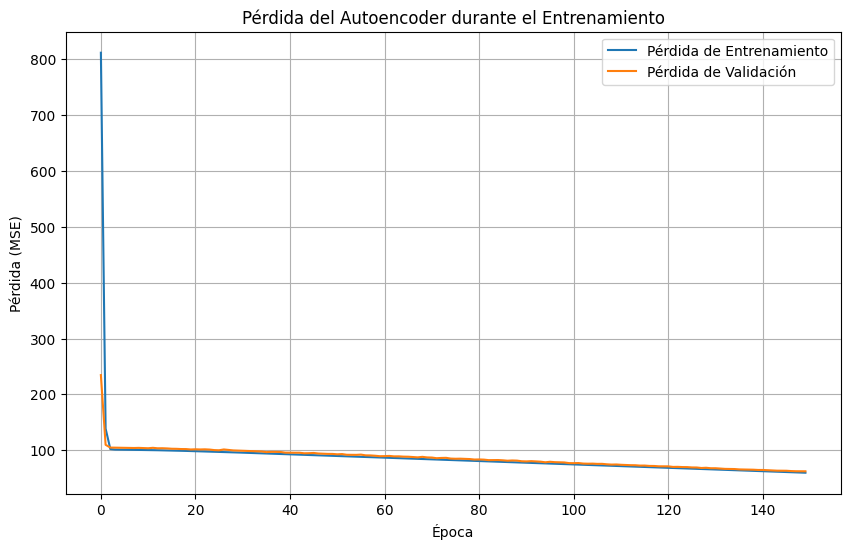

499/499 [==============================] - 1s 1ms/step


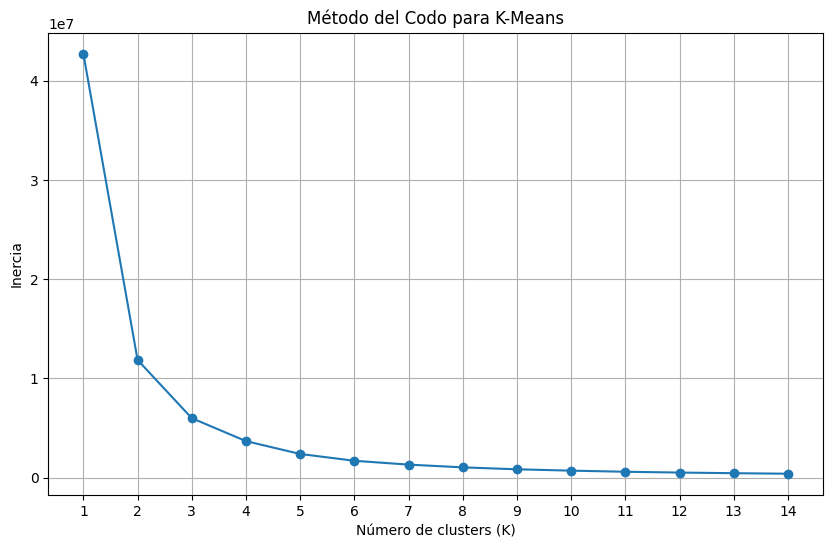


--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---
| Perfil   | Edad   | IMC   | HbA1c   | PAS    | PAD    | LDL    | HDL   | Insulina   | Trigliceridos   |
|:---------|:-------|:------|:--------|:-------|:-------|:-------|:------|:-----------|:----------------|
| 0        | 18     | 15    | 5.05    | 80     | 50     | 50     | 100   | 2          | 30              |
| 1        | 74.23  | 41.7  | 11.67   | 175.67 | 105.62 | 200.72 | 35.88 | 189.21     | 823.52          |
| 2        | 90     | 50    | 15      | 200    | 120    | 250    | 20    | 300        | 1000            |
| 3        | 46.8   | 26.47 | 4       | 119.03 | 72.16  | 131.45 | 70.07 | 87.37      | 388             |

--- Informe Personalizado de Salud y Nutrición para Paciente P0450 ---

## 1. Características del Paciente
---------------------------------
**Edad                  **: 42.40
**Sexo                  **: Mujer
**IMC                   **: 28.73
**HbA1c                 **: 7.20
*

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, RDF, RDFS, Literal
import re

# Cargar datos
try:
    df_diabetes = pd.read_csv('database_imputada.csv')
except FileNotFoundError:
    print("Asegúrate de que 'database_imputada.csv' está en la misma carpeta.")
    exit()

# --- Asegurar que 'ID_Paciente' existe antes de CUALQUIER copia ---
if 'ID_Paciente' not in df_diabetes.columns:
    df_diabetes['ID_Paciente'] = [f'P{i:04d}' for i in range(len(df_diabetes))]
    print("Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.")

# 1. Crear una copia del DataFrame para el display (donde aplicaremos el re-escalado para visualización).
df_diabetes_original_for_display = df_diabetes.copy()

# 2. Crear un DataFrame NUEVO para el preprocesamiento del Autoencoder.
df_autoencoder_processed = df_diabetes.copy()

# --- Definición de Variables ---
# AÑADIMOS 'PAD' A LA LISTA DE VARIABLES NUMÉRICAS
variables_numericas = ['Edad', 'IMC', 'HbA1c', 'PAS', 'PAD', 'LDL', 'HDL', 'Insulina', 'Trigliceridos']
variables_categoricas = ['Sexo', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular']

# --- RANGOS REALISTAS PARA LA VISUALIZACIÓN ---
# ¡ES CRÍTICO QUE AJUSTES ESTOS VALORES SEGÚN EL CONOCIMIENTO CLÍNICO DE TUS DATOS!
# Hemos añadido 'PAD' aquí con un rango típico.
realistic_ranges = {
    'Edad': {'min': 18, 'max': 90},
    'IMC': {'min': 15.0, 'max': 50.0},
    'HbA1c': {'min': 4.0, 'max': 15.0}, # Generalmente en %
    'PAS': {'min': 80, 'max': 200},   # Presión arterial sistólica en mmHg
    'PAD': {'min': 50, 'max': 120},   # Presión arterial diastólica en mmHg (Rango añadido)
    'LDL': {'min': 50, 'max': 250},   # Colesterol LDL en mg/dL
    'HDL': {'min': 20, 'max': 100},   # Colesterol HDL en mg/dL
    'Insulina': {'min': 2.0, 'max': 300.0}, # Insulina en uIU/mL
    'Trigliceridos': {'min': 30.0, 'max': 1000.0} # Triglicéridos en mg/dL (rango amplio)
}

# --- FUNCIÓN DE RE-ESCALADO A RANGO REALISTA ---
def rescale_to_realistic_range(df_input, columns_to_rescale, ranges):
    df_rescaled = df_input.copy()
    for col in columns_to_rescale:
        if col in df_rescaled.columns and col in ranges:
            current_min = df_rescaled[col].min()
            current_max = df_rescaled[col].max()
            
            # Evitar división por cero si todos los valores son iguales
            if current_max == current_min:
                df_rescaled[col] = (ranges[col]['min'] + ranges[col]['max']) / 2
                continue

            # Primero, escalar los valores a un rango de 0 a 1 basado en sus min/max actuales
            df_rescaled[col] = (df_rescaled[col] - current_min) / (current_max - current_min)
            
            # Luego, estirar estos valores 0-1 a nuestro rango deseado
            df_rescaled[col] = df_rescaled[col] * (ranges[col]['max'] - ranges[col]['min']) + ranges[col]['min']
            
            # Finalmente, aplicar un "clipping" para asegurar que los valores no se salgan del rango deseado
            df_rescaled[col] = np.clip(df_rescaled[col], ranges[col]['min'], ranges[col]['max'])
    return df_rescaled

# --- Preparación de datos para el AUTOENCODER (solo en df_autoencoder_processed) ---

# Imputar nulos en df_autoencoder_processed (si los hay después de la carga inicial)
for col in variables_numericas:
    if col in df_autoencoder_processed.columns:
        df_autoencoder_processed[col] = pd.to_numeric(df_autoencoder_processed[col], errors='coerce')
        df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mean(), inplace=True)
    else:
        print(f"Advertencia: La columna numérica '{col}' no se encontró en el archivo CSV y será ignorada.")

for col in variables_categoricas:
    if col in df_autoencoder_processed.columns:
        if df_autoencoder_processed[col].isnull().any():
            df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mode()[0], inplace=True)
    else:
        print(f"Advertencia: La columna categórica '{col}' no se encontró en el archivo CSV y será ignorada.")

# Identificamos las columnas numéricas y categóricas que realmente existen
existing_numeric_cols = [col for col in variables_numericas if col in df_autoencoder_processed.columns]
existing_categorical_cols = [col for col in variables_categoricas if col in df_autoencoder_processed.columns]

X_numericas = df_autoencoder_processed[existing_numeric_cols].values

# Codificar variables categóricas
# Guardamos las categorías originales para una decodificación más precisa
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_categoricas_encoded = encoder.fit_transform(df_autoencoder_processed[existing_categorical_cols]).toarray()

# Concatenar características para el Autoencoder
X_for_autoencoder = np.concatenate([X_numericas, X_categoricas_encoded], axis=1)

# --- Autoencoder y K-Means ---
input_dim = X_for_autoencoder.shape[1]
encoding_dim = 8 # Puedes probar 10 o 12 si los resultados de clustering no son suficientemente claros

# Definición del Autoencoder completo
input_layer = Input(shape=(input_dim,))
encoded = Dense(input_dim // 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded) # Salida del encoder
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded) # Usamos 'linear' para reconstruir cualquier valor real
autoencoder = Model(input_layer, decoded)

# Definición del ENCODER (parte del Autoencoder que mapea la entrada al espacio latente)
encoder_model = Model(input_layer, encoded)

# Definición del DECODER (parte del Autoencoder que reconstruye a partir del espacio latente)
decoder_input = Input(shape=(encoding_dim,))
decoder_output = Dense(encoding_dim * 2, activation='relu')(decoder_input)
decoder_output = Dense(input_dim // 2, activation='relu')(decoder_output)
decoder_output = Dense(input_dim, activation='linear')(decoder_output)
decoder_model = Model(decoder_input, decoder_output)

autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Entrenando Autoencoder ---")
history = autoencoder.fit(X_for_autoencoder, X_for_autoencoder, epochs=150, batch_size=64, validation_split=0.2, verbose=0)
print(f"Pérdida final del Autoencoder (entrenamiento): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final del Autoencoder (validación): {history.history['val_loss'][-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Autoencoder durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

X_encoded = encoder_model.predict(X_for_autoencoder)

# Método del Codo para determinar el número óptimo de clusters (K)
inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

k_optimo = 4 # Mantendremos 4 como óptimo por ahora, puedes ajustarlo si el codo sugiere otro valor
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)

# Asignar perfiles al DataFrame que se usó para el Autoencoder
df_autoencoder_processed['Perfil'] = kmeans.fit_predict(X_encoded)

# Transferir el 'Perfil' al DataFrame de display
df_diabetes_original_for_display['Perfil'] = df_autoencoder_processed['Perfil']


# --- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---
# Primero obtenemos los promedios de los valores tal como vienen en el CSV (que ya pueden estar escalados).
perfiles_stats_raw = df_diabetes_original_for_display.groupby('Perfil')[existing_numeric_cols].mean()

# Luego, aplicamos la función de re-escalado a estos promedios para hacerlos realistas en la visualización.
perfiles_stats_display = rescale_to_realistic_range(perfiles_stats_raw, existing_numeric_cols, realistic_ranges)

print("\n--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---")
print(perfiles_stats_display.round(2).to_markdown(numalign="left", stralign="left"))


# --- Construcción de la Ontología (sin cambios en la lógica) ---
g = Graph()

FOOD = Namespace("http://example.org/food/")
NUT = Namespace("http://example.org/nutrient/")
COND = Namespace("http://example.org/condition/")
EX = Namespace("http://example.org/ex/")
PROF = Namespace("http://example.org/profile/")

g.bind("food", FOOD)
g.bind("nut", NUT)
g.bind("cond", COND)
g.bind("ex", EX)
g.bind("prof", PROF)

g.add((FOOD.Food, RDF.type, RDFS.Class))
g.add((NUT.Nutrient, RDF.type, RDFS.Class))
g.add((COND.Condition, RDF.type, RDFS.Class))
g.add((PROF.Profile, RDF.type, RDFS.Class))

g.add((EX.hasCondition, RDF.type, RDF.Property))
g.add((EX.beneficialFor, RDF.type, RDF.Property))
g.add((EX.harmfulFor, RDF.type, RDF.Property))
g.add((NUT.containsNutrient, RDF.type, RDF.Property))
g.add((PROF.hasNutritionalRecommendation, RDF.type, RDF.Property))

for profile_id in df_autoencoder_processed['Perfil'].unique():
    profile_uri = getattr(PROF, f"Profile_{profile_id}")
    g.add((profile_uri, RDF.type, PROF.Profile))

# Nutrientes y sus beneficios
nutrient_benefits = {
    "Fiber": ["Diabetes", "HighCholesterol", "Overweight"],
    "Omega3": ["Hypertension", "HighCholesterol", "Diabetes"],
    "Calcium": ["Hypertension", "Underweight"],
    "Magnesium": ["Hypertension", "Diabetes"],
    "Protein": ["Underweight", "Diabetes", "Overweight"],
    "VitaminD": ["HighCholesterol", "Diabetes", "Underweight"],
    "Potassium": ["Hypertension"],
    "Antioxidants": ["Diabetes", "HighCholesterol"]
}

for nutrient, conditions in nutrient_benefits.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.beneficialFor, getattr(COND, condition_name)))

# Nutrientes cuyo consumo se debe DISMINUIR
nutrient_harms = {
    "Sodium": ["Hypertension"],
    "SaturatedFat": ["HighCholesterol", "Diabetes"],
    "SimpleSugars": ["Diabetes", "Overweight"]
}

for nutrient, conditions in nutrient_harms.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.harmfulFor, getattr(COND, condition_name)))

# Alimentos y sus nutrientes
food_nutrients = {
    "Salmon": ["Omega3", "Protein", "VitaminD"],
    "Walnuts": ["Omega3", "Magnesium", "Antioxidants", "Protein", "Fiber"],
    "Lentils": ["Fiber", "Protein", "Magnesium"],
    "Spinach": ["Magnesium", "Calcium", "Fiber", "Antioxidants"],
    "Yogurt": ["Calcium", "Protein"],
    "Oats": ["Fiber", "Magnesium", "Protein"],
    "Blueberries": ["Antioxidants", "Fiber"],
    "Almonds": ["Magnesium", "Protein", "Fiber", "Antioxidants"],
}

for food, nutrients in food_nutrients.items():
    g.add((getattr(FOOD, food), RDF.type, FOOD.Food))
    for nutrient in nutrients:
        g.add((getattr(FOOD, food), NUT.containsNutrient, getattr(NUT, nutrient)))

# Función para obtener condiciones del paciente individual.
# Ahora 'patient_data_row' viene de 'df_diabetes_original_for_display', que tendrá los valores re-escalados.
def get_patient_conditions(patient_data_row):
    conditions = set()

    hba1c = patient_data_row.get('HbA1c', 0)
    pas = patient_data_row.get('PAS', 0)
    ldl = patient_data_row.get('LDL', 0)
    imc = patient_data_row.get('IMC', 0)
    # También obtenemos PAD para las condiciones si la incluyes en tu lógica de condiciones
    pad = patient_data_row.get('PAD', 0)
    
    if patient_data_row.get('Diabetes') == 1:
        conditions.add("Diabetes")
    elif hba1c > 6.5 and "Diabetes" not in conditions: # Asumiendo que HbA1c > 6.5% indica diabetes
        conditions.add("Diabetes")

    # Consideramos PAS y PAD para hipertensión
    if pas > 130 or pad > 80: # Asumiendo PAS > 130 mmHg o PAD > 80 mmHg indica hipertensión
        conditions.add("Hypertension")
    if ldl > 100: # Asumiendo LDL > 100 mg/dL indica colesterol alto
        conditions.add("HighCholesterol")
    if imc > 25: # Asumiendo IMC > 25 indica sobrepeso
        conditions.add("Overweight")
    elif imc < 18.5: # Asumiendo IMC < 18.5 indica bajo peso
        conditions.add("Underweight")
        
    return list(conditions)

# Función para obtener los nutrientes recomendados (sin cambios en la lógica)
def get_recommended_nutrients_for_patient(patient_conditions):
    nutrients_to_increase = set()
    nutrients_to_decrease = set()

    for condition_name in patient_conditions:
        condition_uri = getattr(COND, condition_name)
        
        beneficial_nuts = [subj for subj, pred, obj in g.triples((None, EX.beneficialFor, condition_uri))]
        nutrients_to_increase.update([str(n).split('/')[-1] for n in beneficial_nuts])

        harmful_nuts = [subj for subj, pred, obj in g.triples((None, EX.harmfulFor, condition_uri))]
        nutrients_to_decrease.update([str(n).split('/')[-1] for n in harmful_nuts])
        
    return sorted(list(nutrients_to_increase)), sorted(list(nutrients_to_decrease))

# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    # Usamos el DataFrame 'df_diabetes_original_for_display' que tendrá los valores re-escalados para mostrar.
    patient_data = df_diabetes_original_for_display[df_diabetes_original_for_display['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    # Aseguramos que PAD esté en la lista de columnas a mostrar
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'PAS', 'PAD', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 
                    'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 
                    'Tipo_Diabetes_imputada', 'Riesgo_Cardiovascular', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        
        if isinstance(value, (int, float)):
            if col == 'Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            elif col == 'Perfil':
                patient_info_dict[col] = str(int(value))
            else: # Los valores numéricos ya están re-escalados para display
                patient_info_dict[col] = f"{value:.2f}"
        elif pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        else: # Columnas categóricas (cadenas de texto)
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            print(f"- **{cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Aplicar el re-escalado a los datos de display ANTES de generar el informe de un paciente específico
df_diabetes_original_for_display = rescale_to_realistic_range(df_diabetes_original_for_display, existing_numeric_cols, realistic_ranges)

# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0450' # Puedes cambiar a cualquier ID de paciente de tu CSV
display_patient_recommendations(patient_id_to_check)